### Google Doc File : https://docs.google.com/document/d/14BvO7FcM70Ti601LYFrhvsd2bOynnWx7zIw7ddQspVE/edit?usp=sharing

In [259]:
# from google.colab import drive
# drive.mount('/content/drive')

## Multiple Drivers at once

In [260]:
import os
import pandas as pd
import numpy as np

def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000  # convert to meters

    return distance

def process_log_line(line):
    if "Feedback Code Starting" in line:
        return None

    sections = line.split(' :- ')

    if len(sections) != 2:
        return None

    log_timestamp = sections[0].strip().split(',')[0]
    log_details = sections[1].strip()

    details_parts = log_details.split(':')
    log_seq = details_parts[0]
    data_dict = {'Log_seq': int(log_seq)}

    mabx_values = [item.strip() for item in details_parts[1:]]
    data_dict['Timestamp'] = log_timestamp
    seq, veh_speed, tire_angle = map(float, mabx_values[0].split('||')[0].split(','))

    data_dict['MABX_seq'] = int(seq)
    data_dict['Veh_MABX_Speed'] = veh_speed
    data_dict['Tire_Angle'] = tire_angle

    # unix_time = mabx_values[0].split('||')[1].strip().split(',')[0]
    
    gnss_values = mabx_values[0].split('||')[1].strip().split(',')
    if len(gnss_values) == 10:
        unixtime, lat, lng, lat_std, lng_std, gnss_speed, acc, roll, pitch, heading = map(float, gnss_values)
        data_dict['Unixtime'] = int(unixtime)
        data_dict['Lat'] = lat
        data_dict['Lng'] = lng
        data_dict['Lat_std'] = lat_std
        data_dict['Lng_std'] = lng_std
        data_dict['Veh_GNSS_Speed'] = gnss_speed
        data_dict['Z_Acc'] = acc
        data_dict['Roll'] = roll
        data_dict['Pitch'] = pitch
        data_dict['Heading'] = heading
    else:
        # print(f"Skipping line due to unexpected number of values: {len(gnss_values)} in line: {line}")
        return None

    return data_dict

def read_and_process_log_file(file_path, dataframe):
    with open(file_path, 'r') as file:
        file_content = file.read()

    file_lines = file_content.split('\n')

    data_list = []

    for line in file_lines:
        data_dict = process_log_line(line)
        if data_dict is not None:
            data_list.append(data_dict)

    if data_list:
        dataframe = pd.concat([dataframe, pd.DataFrame(data_list)], ignore_index=True)

    return dataframe

data = {}

#Specify the directory path
directory_path1= '/Users/ravitejakunchanapalli/Downloads/autonomous-mode 3/rookie'
directory_path2= '/Users/ravitejakunchanapalli/Downloads/autonomous-mode 3/intermediate'
directory_path3='/Users/ravitejakunchanapalli/Downloads/autonomous-mode 3/expert'

directory_path = directory_path2

items = os.listdir(directory_path)
items.sort()
folder_paths = [os.path.join(directory_path, item) for item in items if os.path.isdir(os.path.join(directory_path, item))]
# Process log files in each folder path
for folder_path in folder_paths:
    folder_name = os.path.basename(os.path.normpath(folder_path))  # Get the last word of the path

    # Initialize DataFrames for each type
    auto10_df = pd.DataFrame()
    auto20_df = pd.DataFrame()
    auto30_df = pd.DataFrame()

    for filename in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith(".log") and os.path.isfile(file_path):
            if 'auto10' in filename:
                auto10_df = read_and_process_log_file(file_path, auto10_df)
                auto10_df['dist_from_start'] = haversine_vectorized(auto10_df['Lat'][0], auto10_df['Lng'][0], auto10_df['Lat'], auto10_df['Lng'])
            elif 'auto20' in filename:
                auto20_df = read_and_process_log_file(file_path, auto20_df)
                auto20_df['dist_from_start'] = haversine_vectorized(auto20_df['Lat'][0], auto20_df['Lng'][0], auto20_df['Lat'], auto20_df['Lng'])
            elif 'auto30' in filename:
                auto30_df = read_and_process_log_file(file_path, auto30_df)
                auto30_df['dist_from_start'] = haversine_vectorized(auto30_df['Lat'][0], auto30_df['Lng'][0], auto30_df['Lat'], auto30_df['Lng'])

    # Add the DataFrames to the main data dictionary using the folder name as the key
    data[folder_name] = {
        'auto10': auto10_df.copy(),
        'auto20': auto20_df.copy(),
        'auto30': auto30_df.copy(),
    }

    # Confirm that the dataframes are not empty
    for key, value in data[folder_name].items():
        if value.empty:
            print(f"Empty DataFrame for {folder_name} - {key}")


### Some Information about the dataframe

In [261]:
data['Rishav']['auto20'].head(5)

,Log_seq,Timestamp,MABX_seq,Veh_MABX_Speed,Tire_Angle,Unixtime,Lat,Lng,Lat_std,Lng_std,Veh_GNSS_Speed,Z_Acc,Roll,Pitch,Heading,dist_from_start
0,2,2024-01-22 16:16:25,124,20.0,0.1,1705920385,17.601639,78.12661,0.01,0.01,25.47,9.62,1.11,-0.49,359.52,0.000000
1,3,2024-01-22 16:16:25,127,20.0,0.1,1705920385,17.601639,78.12661,0.01,0.01,25.47,9.75,1.10,-0.50,359.51,0.000000
2,4,2024-01-22 16:16:25,130,20.0,0.1,1705920385,17.601639,78.12661,0.01,0.01,25.47,10.01,1.11,-0.48,359.50,0.000000
3,5,2024-01-22 16:16:25,133,20.0,0.1,1705920385,17.601646,78.12661,0.01,0.01,25.49,9.88,1.12,-0.50,359.49,0.711248
4,6,2024-01-22 16:16:25,136,20.0,0.1,1705920385,17.601646,78.12661,0.01,0.01,25.49,10.05,1.13,-0.50,359.47,0.711248


In [262]:
data['Rishav']['auto20'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Log_seq          614 non-null    int64  
 1   Timestamp        614 non-null    object 
 2   MABX_seq         614 non-null    int64  
 3   Veh_MABX_Speed   614 non-null    float64
 4   Tire_Angle       614 non-null    float64
 5   Unixtime         614 non-null    int64  
 6   Lat              614 non-null    float64
 7   Lng              614 non-null    float64
 8   Lat_std          614 non-null    float64
 9   Lng_std          614 non-null    float64
 10  Veh_GNSS_Speed   614 non-null    float64
 11  Z_Acc            614 non-null    float64
 12  Roll             614 non-null    float64
 13  Pitch            614 non-null    float64
 14  Heading          614 non-null    float64
 15  dist_from_start  614 non-null    float64
dtypes: float64(12), int64(3), object(1)
memory usage: 76.9+ KB


In [263]:
data['Rishav']['auto10'].describe()

,Log_seq,MABX_seq,Veh_MABX_Speed,Tire_Angle,Unixtime,Lat,Lng,Lat_std,Lng_std,Veh_GNSS_Speed,Z_Acc,Roll,Pitch,Heading,dist_from_start
count,971.000000,971.000000,971.000000,971.000000,9.710000e+02,971.000000,971.000000,9.710000e+02,9.710000e+02,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000
mean,497.580844,129.284243,12.006282,-0.058805,1.706076e+09,17.602075,78.126604,1.000000e-02,1.000000e-02,12.271473,9.812080,1.142327,-0.201318,359.058970,43.759820
std,288.486242,74.748620,5.017661,0.113120,8.558018e+00,0.000253,0.000004,1.683549e-16,1.683549e-16,5.124592,0.601097,0.409375,0.319405,0.431359,28.189943
min,2.000000,0.000000,4.000000,-0.200000,1.706076e+09,17.601681,78.126599,1.000000e-02,1.000000e-02,4.090000,0.140000,0.420000,-1.400000,358.340000,0.000000
25%,247.500000,64.000000,10.000000,-0.100000,1.706076e+09,17.601868,78.126600,1.000000e-02,1.000000e-02,10.080000,9.680000,0.805000,-0.360000,358.740000,20.813463
50%,495.000000,131.000000,10.000000,-0.100000,1.706076e+09,17.602055,78.126603,1.000000e-02,1.000000e-02,10.230000,9.810000,1.130000,-0.220000,359.090000,41.552724
75%,747.500000,193.000000,13.800000,-0.100000,1.706076e+09,17.602238,78.126608,1.000000e-02,1.000000e-02,14.100000,9.940000,1.440000,-0.020000,359.300000,61.953263
max,998.000000,255.000000,24.000000,0.800000,1.706076e+09,17.602590,78.126609,1.000000e-02,1.000000e-02,24.660000,16.320000,2.150000,0.540000,359.980000,101.118043


### Boxplot

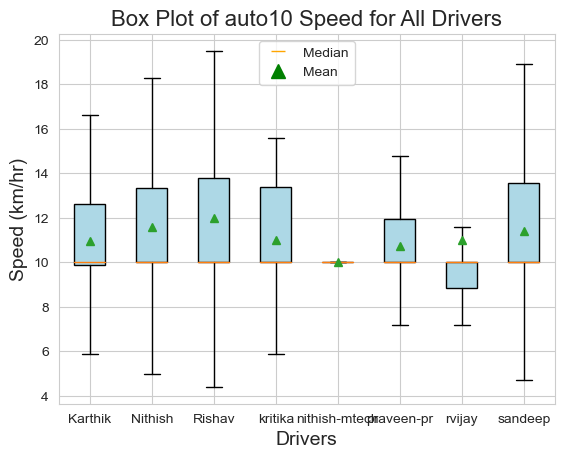

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set seaborn style
sns.set_style("whitegrid")

# List to store boxplot labels and data
boxplot_data1 = []

# Iterate over each folder (driver)
for folder_name, folder_data in data.items():
    # Check if 'normal' data exists for the current driver
    if 'auto10' in folder_data:
        boxplot_data1.append(folder_data['auto10']['Veh_MABX_Speed'])

# Create the box plot
bp = plt.boxplot(boxplot_data1, labels=data.keys(), patch_artist=True, showmeans=True, meanline=False, showfliers=False)

colors = ['lightblue'] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Create dummy lines for legend
median_line = mlines.Line2D([], [], color='orange', marker='_', linestyle='None', markersize=10, label='Median')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[median_line, mean_line])

plt.xlabel('Drivers', fontsize=14)
plt.ylabel('Speed (km/hr)', fontsize=14)
plt.title('Box Plot of auto10 Speed for All Drivers', fontsize=16)
plt.show()


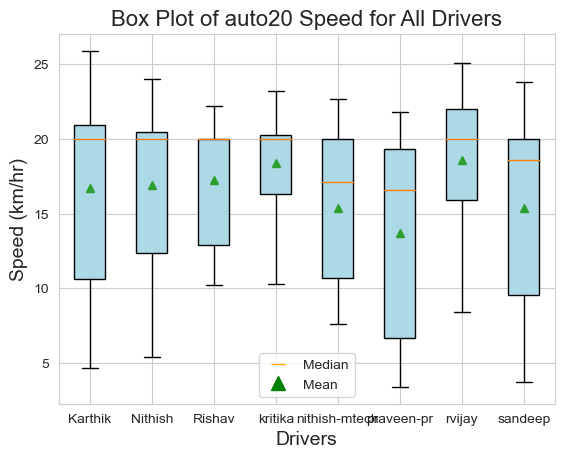

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set seaborn style
sns.set_style("whitegrid")

# List to store boxplot labels and data
boxplot_data1 = []

# Iterate over each folder (driver)
for folder_name, folder_data in data.items():
    # Check if 'normal' data exists for the current driver
    if 'auto20' in folder_data:
        boxplot_data1.append(folder_data['auto20']['Veh_MABX_Speed'])

# Create the box plot
bp = plt.boxplot(boxplot_data1, labels=data.keys(), patch_artist=True, showmeans=True, meanline=False, showfliers=False)

colors = ['lightblue'] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Create dummy lines for legend
median_line = mlines.Line2D([], [], color='orange', marker='_', linestyle='None', markersize=10, label='Median')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[median_line, mean_line])

plt.xlabel('Drivers', fontsize=14)
plt.ylabel('Speed (km/hr)', fontsize=14)
plt.title('Box Plot of auto20 Speed for All Drivers', fontsize=16)
plt.show()

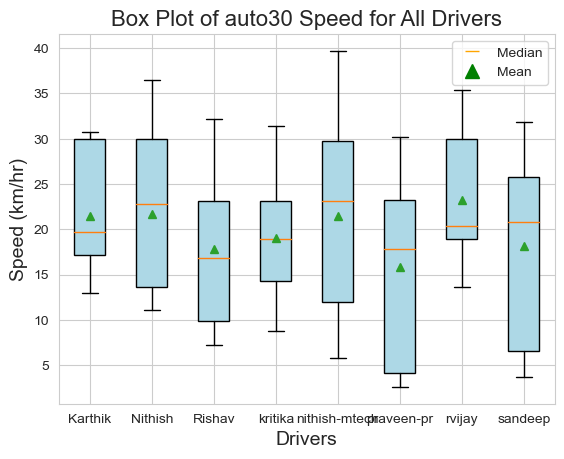

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Set seaborn style
sns.set_style("whitegrid")

# List to store boxplot labels and data
boxplot_data1 = []

# Iterate over each folder (driver)
for folder_name, folder_data in data.items():
    # Check if 'normal' data exists for the current driver
    if 'auto30' in folder_data:
        boxplot_data1.append(folder_data['auto30']['Veh_MABX_Speed'])

# Create the box plot
bp = plt.boxplot(boxplot_data1, labels=data.keys(), patch_artist=True, showmeans=True, meanline=False, showfliers=False)

colors = ['lightblue'] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Create dummy lines for legend
median_line = mlines.Line2D([], [], color='orange', marker='_', linestyle='None', markersize=10, label='Median')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[median_line, mean_line])

plt.xlabel('Drivers', fontsize=14)
plt.ylabel('Speed (km/hr)', fontsize=14)
plt.title('Box Plot of auto30 Speed for All Drivers', fontsize=16)
plt.show()

### Checking Z_Acceleration

In [267]:
max_min_z_acc = {}

for user_name, user_data in data.items():
    max_min_z_acc[user_name] = {}
    for df_name, df in user_data.items():
        max_z_acc_idx = df['Z_Acc'].idxmax()
        min_z_acc_idx = df['Z_Acc'].idxmin()
        
        max_z_acc = df.loc[max_z_acc_idx, 'Z_Acc']
        min_z_acc = df.loc[min_z_acc_idx, 'Z_Acc']
        
        max_z_acc_dist = df.loc[max_z_acc_idx, 'dist_from_start']
        min_z_acc_dist = df.loc[min_z_acc_idx, 'dist_from_start']
        
        max_min_z_acc[user_name][df_name] = {'max': max_z_acc, 'max_dist': max_z_acc_dist, 'min': min_z_acc, 'min_dist': min_z_acc_dist}

max_min_z_acc

{'Karthik': {'auto10': {'max': 17.42,
   'max_dist': 50.526888989568214,
   'min': 5.85,
   'min_dist': 50.27709015201475},
  'auto20': {'max': 17.54,
   'max_dist': 51.516318273416054,
   'min': 3.09,
   'min_dist': 51.139392000737374},
  'auto30': {'max': 25.44,
   'max_dist': 53.85428635009635,
   'min': -5.9,
   'min_dist': 54.24984625763137}},
 'Nithish': {'auto10': {'max': 15.7,
   'max_dist': 55.225793559419785,
   'min': 0.8,
   'min_dist': 55.47583860706672},
  'auto20': {'max': 14.89,
   'max_dist': 56.0234605973606,
   'min': 1.94,
   'min_dist': 55.507096193265546},
  'auto30': {'max': 21.35,
   'max_dist': 56.82473995865205,
   'min': 0.15,
   'min_dist': 56.82473995865205}},
 'Rishav': {'auto10': {'max': 16.32,
   'max_dist': 49.869371981425864,
   'min': 0.14,
   'min_dist': 50.37324546240531},
  'auto20': {'max': 18.19,
   'max_dist': 54.56831409936853,
   'min': 0.12,
   'min_dist': 54.87932960746219},
  'auto30': {'max': 16.35,
   'max_dist': 53.739594596675005,
   'm

In [268]:
ending_point = {}

for user_name, user_data in data.items():
    ending_point[user_name] = {}
    for df_name, df in user_data.items():
        max_z_acc_index = df['Z_Acc'].idxmax()
        ending_point[user_name][df_name] = max_z_acc_index

ending_point

{'Karthik': {'auto10': 672, 'auto20': 327, 'auto30': 246},
 'Nithish': {'auto10': 674, 'auto20': 370, 'auto30': 220},
 'Rishav': {'auto10': 624, 'auto20': 325, 'auto30': 926},
 'kritika': {'auto10': 618, 'auto20': 279, 'auto30': 186},
 'nithish-mtech': {'auto10': 528, 'auto20': 262, 'auto30': 214},
 'praveen-pr': {'auto10': 653, 'auto20': 386, 'auto30': 365},
 'rvijay': {'auto10': 627, 'auto20': 288, 'auto30': 224},
 'sandeep': {'auto10': 604, 'auto20': 342, 'auto30': 289}}

In [269]:
ending_point = {}

for user_name, user_data in data.items():
    ending_point[user_name] = {}
    for df_name, df in user_data.items():
        max_z_acc_index = df['Z_Acc'].idxmax()
        ending_point[user_name][df_name] = max_z_acc_index

starting_point = {}

for user_name, user_data in data.items():
    starting_point[user_name] = {}
    for df_name, df in user_data.items():
        
        if 'auto10' in df_name:
            speed = 10.0
        elif 'auto20' in df_name:
            speed = 20.0
        elif 'auto30' in df_name:
            speed = 30.0

        indices_for_speed = df[df['Veh_MABX_Speed'] == speed].index
        indices_for_speed = indices_for_speed[indices_for_speed < ending_point[user_name][df_name] ]
        
        if not indices_for_speed.empty:
            max_speed_idx = indices_for_speed[-1]
            starting_point[user_name][df_name] = max_speed_idx
        else:
            starting_point[user_name][df_name] = None

print(starting_point)
print(ending_point)

{'Karthik': {'auto10': 489, 'auto20': 146, 'auto30': 154}, 'Nithish': {'auto10': 518, 'auto20': 218, 'auto30': 168}, 'Rishav': {'auto10': 444, 'auto20': 205, 'auto30': 363}, 'kritika': {'auto10': 496, 'auto20': 184, 'auto30': 75}, 'nithish-mtech': {'auto10': 527, 'auto20': 186, 'auto30': 115}, 'praveen-pr': {'auto10': 497, 'auto20': 175, 'auto30': 112}, 'rvijay': {'auto10': 510, 'auto20': 174, 'auto30': 180}, 'sandeep': {'auto10': 442, 'auto20': 181, 'auto30': 120}}
{'Karthik': {'auto10': 672, 'auto20': 327, 'auto30': 246}, 'Nithish': {'auto10': 674, 'auto20': 370, 'auto30': 220}, 'Rishav': {'auto10': 624, 'auto20': 325, 'auto30': 926}, 'kritika': {'auto10': 618, 'auto20': 279, 'auto30': 186}, 'nithish-mtech': {'auto10': 528, 'auto20': 262, 'auto30': 214}, 'praveen-pr': {'auto10': 653, 'auto20': 386, 'auto30': 365}, 'rvijay': {'auto10': 627, 'auto20': 288, 'auto30': 224}, 'sandeep': {'auto10': 604, 'auto20': 342, 'auto30': 289}}


#### gnss

In [270]:
# import numpy as np

# ending_point = {}

# for user_name, user_data in data.items():
#     ending_point[user_name] = {}
#     for df_name, df in user_data.items():
#         max_z_acc_index = df['Z_Acc'].idxmax()
#         ending_point[user_name][df_name] = max_z_acc_index

# starting_point = {}

# for user_name, user_data in data.items():
#     starting_point[user_name] = {}
#     for df_name, df in user_data.items():
        
#         if 'auto10' in df_name:
#             speed = 10.0
#         elif 'auto20' in df_name:
#             speed = 20.0
#         elif 'auto30' in df_name:
#             speed = 30.0

#         tolerance = 0.1  # Adjust the tolerance as needed

#         # indices_for_speed = df[df['Veh_MABX_Speed'] == speed].index
#         indices_for_speed = df[np.isclose(df['Veh_GNSS_Speed'], speed, rtol=tolerance)].index
#         indices_for_speed = indices_for_speed[indices_for_speed < ending_point[user_name][df_name] ]
        
#         if not indices_for_speed.empty:
#             max_speed_idx = indices_for_speed[-1]
#             starting_point[user_name][df_name] = max_speed_idx
#         else:
#             starting_point[user_name][df_name] = None

# print(starting_point)
# print(ending_point)

##### For all users Reaction distance 

In [271]:
reaction_distance = {}

for user_name, user_data in data.items():
    reaction_distance[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['dist_from_start']
        else:
            reaction_distance[user_name][df_name] = None
    
reaction_distance


{'Karthik': {'auto10': 7.112749386815651,
  'auto20': 20.595645796413514,
  'auto30': 16.38761376327465},
 'Nithish': {'auto10': 9.437121073489344,
  'auto20': 11.45893479047556,
  'auto30': 9.797857757407627},
 'Rishav': {'auto10': 11.607069079492916,
  'auto20': 14.121884298578195,
  'auto30': 23.292478786670213},
 'kritika': {'auto10': 7.59972460942307,
  'auto20': 14.047954591411987,
  'auto30': 16.061325635330377},
 'nithish-mtech': {'auto10': 0.0,
  'auto20': 9.035227775918571,
  'auto30': 11.629331338867665},
 'praveen-pr': {'auto10': 7.023060585957467,
  'auto20': 14.519914200763111,
  'auto30': 22.03669500145664},
 'rvijay': {'auto10': 8.444456735562142,
  'auto20': 16.143244590602926,
  'auto30': 9.308156027389359},
 'sandeep': {'auto10': 9.84267545099614,
  'auto20': 10.865761910686558,
  'auto30': 15.407641218511863}}

In [272]:
reaction_distance_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Rishav'].keys():
    reaction_distance_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_distance_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['dist_from_start'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['dist_from_start']
        else:
            reaction_distance_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_distance_df = pd.DataFrame(reaction_distance_mean)

# Calculate the mean for each DataFrame
reaction_distance = reaction_distance_df.mean(axis=0).to_dict()

print(reaction_distance)


{'auto10': 7.633357115217091, 'auto20': 13.848570994356303, 'auto30': 15.49013744111355}


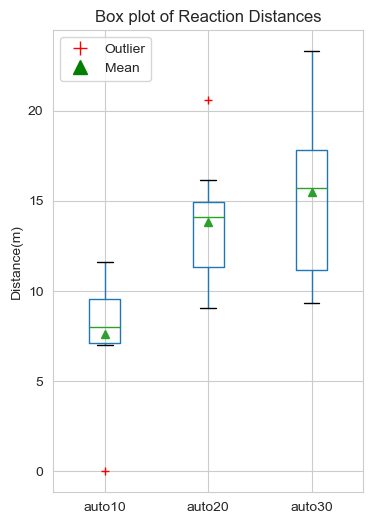

In [273]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_distance_df.boxplot(sym='r+', showmeans=True)
plt.title('Box plot of Reaction Distances')
plt.ylabel('Distance(m)')
plt.xticks()  # Rotate x-axis labels for better visibility if needed

outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])

plt.show()

#### For all users Reaction time

In [274]:
reaction_time = {}

for user_name, user_data in data.items():
    reaction_time[user_name] = {}
    for df_name, df in user_data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time[user_name][df_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time[user_name][df_name] = None
    
reaction_time

{'Karthik': {'auto10': 6, 'auto20': 6, 'auto30': 3},
 'Nithish': {'auto10': 5, 'auto20': 5, 'auto30': 2},
 'Rishav': {'auto10': 6, 'auto20': 4, 'auto30': 5},
 'kritika': {'auto10': 4, 'auto20': 3, 'auto30': 3},
 'nithish-mtech': {'auto10': 0, 'auto20': 2, 'auto30': 3},
 'praveen-pr': {'auto10': 5, 'auto20': 7, 'auto30': 8},
 'rvijay': {'auto10': 4, 'auto20': 4, 'auto30': 1},
 'sandeep': {'auto10': 5, 'auto20': 5, 'auto30': 5}}

In [275]:
reaction_time_mean = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Rishav'].keys():
    reaction_time_mean[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            reaction_time_mean[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Unixtime'] - data[user_name][df_name].iloc[starting_point[user_name][df_name]]['Unixtime']
        else:
            reaction_time_mean[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
reaction_time_df = pd.DataFrame(reaction_time_mean)

# Calculate the mean for each DataFrame
mean_time = reaction_time_df.mean(axis=0).to_dict()

print(mean_time)


{'auto10': 4.375, 'auto20': 4.5, 'auto30': 3.75}


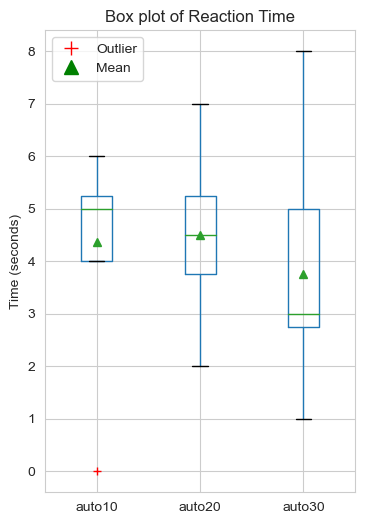

In [276]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
reaction_time_df.boxplot(sym='r+', showmeans=True, )
plt.title('Box plot of Reaction Time')
plt.ylabel('Time (seconds)')

outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])

plt.xticks()  # Rotate x-axis labels for better visibility if needed
plt.show()

#### Average Speed at SpeedBreaker

In [277]:
#find average speed at endpoints
speeds = {}

# Iterate over each DataFrame (df_name)
for df_name in data['Rishav'].keys():
    speeds[df_name] = {}
    
    # Iterate over each user
    for user_name, user_data in data.items():
        if starting_point[user_name][df_name] is not None and ending_point[user_name][df_name] is not None:
            speeds[df_name][user_name] = data[user_name][df_name].iloc[ending_point[user_name][df_name]]['Veh_MABX_Speed']
        else:
            speeds[df_name][user_name] = None

# Convert the nested dictionary to a DataFrame for easier mean calculation
speed_df = pd.DataFrame(speeds)

# Calculate the mean for each DataFrame
mean_speed = speed_df.mean(axis=0).to_dict()

print(mean_speed)

{'auto10': 6.525, 'auto20': 7.275, 'auto30': 9.6875}


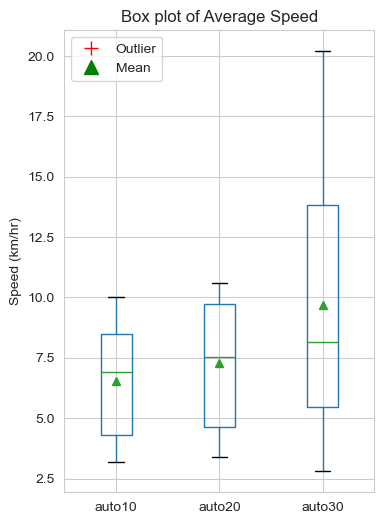

In [278]:
# Draw a box plot of the DataFrame
plt.figure(figsize=(4, 6))  # Adjust the size as needed
speed_df.boxplot(sym='r+', showmeans=True, )
plt.title('Box plot of Average Speed')
plt.ylabel('Speed (km/hr)')

outlier_line = mlines.Line2D([], [], color='red', marker='+', linestyle='None', markersize=10, label='Outlier')
mean_line = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=10, label='Mean')

plt.legend(handles=[outlier_line, mean_line])

plt.xticks()  # Rotate x-axis labels for better visibility if needed
plt.show()

## Alls users in each subplot

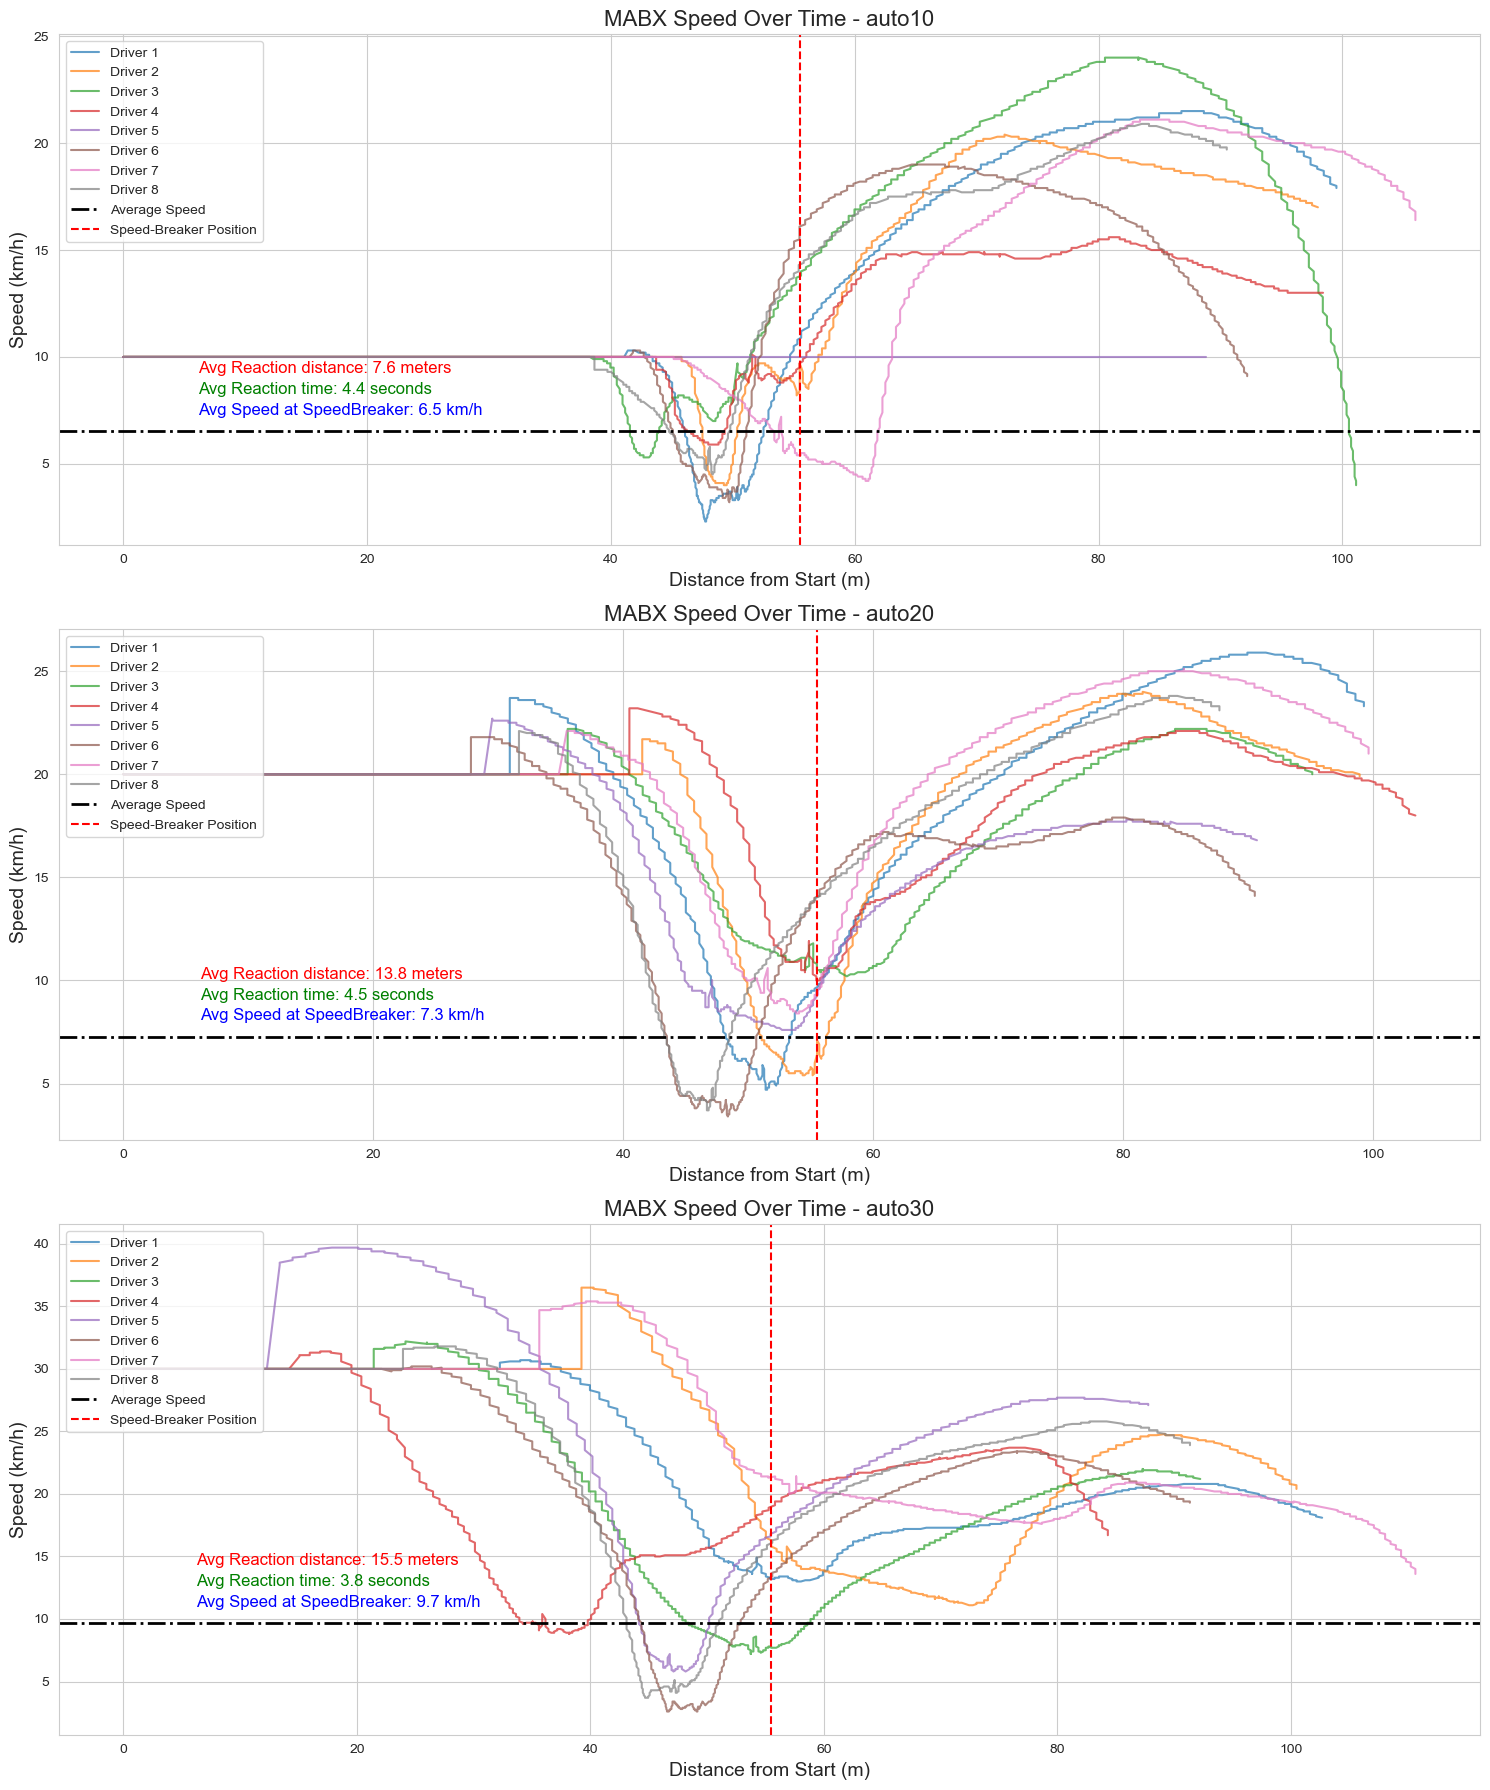

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure with 3 subplots (one for each dataset)
fig, axs = plt.subplots(num_datasets, 1, figsize=(15, 6 * num_datasets))

# Use a colormap for user differentiation
cmap = plt.get_cmap('tab10')

for i, (df_name, df) in enumerate(next(iter(data.values())).items()):  # Iterate over datasets
    for j, (user_name, user_data) in enumerate(data.items()):  # Iterate over users
        user_df = user_data[df_name]  # Get the specific dataset for the current user

        x_value = 55.5  

        # Add speed at x_value to the list
        x_value_speed = user_df.loc[user_df['dist_from_start'] == x_value, 'Veh_MABX_Speed'].values
        if x_value_speed.size > 0:
            speedbreaker_speeds.append(x_value_speed[0])

        # Plot all users' data on the same subplot for the current dataset
        axs[i].plot(user_df['dist_from_start'], user_df['Veh_MABX_Speed'], label=f'Driver {j+1}', color=cmap(j % 10), alpha=0.7)

    if 'auto10' in df_name:
        axs[i].axhline(y=mean_speed['auto10'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto10']
        avg_reacton_time = mean_time['auto10']
        avg_reaction_distance = reaction_distance['auto10']
    elif 'auto20' in df_name:
        axs[i].axhline(y=mean_speed['auto20'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto20']
        avg_reacton_time = mean_time['auto20']
        avg_reaction_distance = reaction_distance['auto20']
    elif 'auto30' in df_name:
        axs[i].axhline(y=mean_speed['auto30'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto30']
        avg_reacton_time = mean_time['auto30']
        avg_reaction_distance = reaction_distance['auto30']

    # Draw a vertical line at x_value and annotate it with the average speed at that point
    axs[i].axvline(x=x_value, color='r', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at SpeedBreaker: {avg_x_value_speed:.1f} km/h', (5, avg_x_value_speed), xytext=(10, 15),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='blue')
    axs[i].annotate(f'Avg Reaction time: {avg_reacton_time:.1f} seconds', (5, avg_x_value_speed), xytext=(10, 30),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='green')
    axs[i].annotate(f'Avg Reaction distance: {avg_reaction_distance:.1f} meters', (5, avg_x_value_speed), xytext=(10, 45),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='red')

    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'MABX Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


#### Moving Average

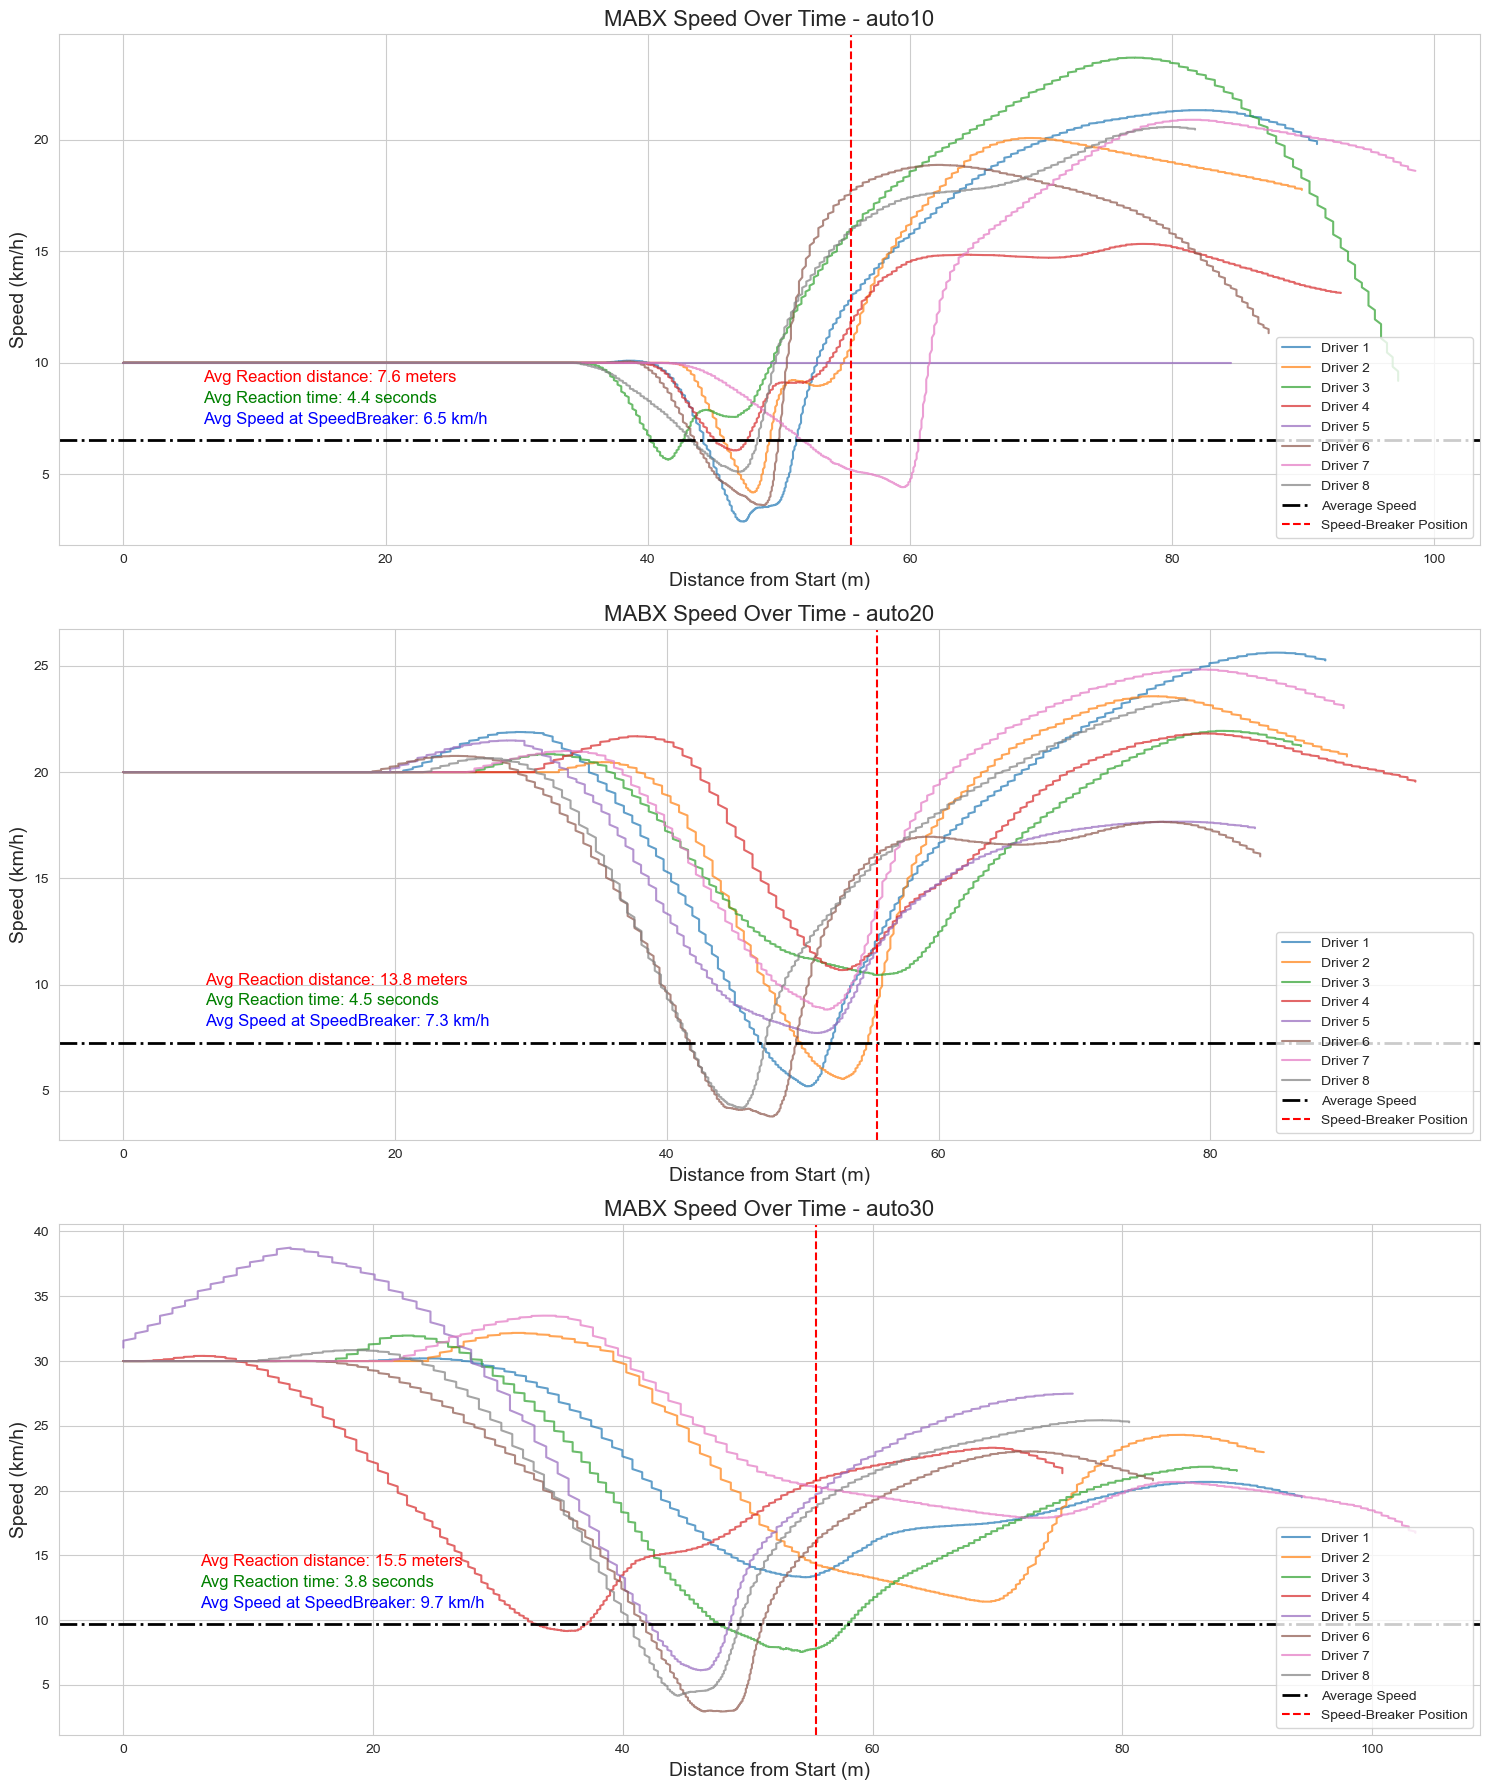

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure with 3 subplots (one for each dataset)
fig, axs = plt.subplots(num_datasets, 1, figsize=(15, 6 * num_datasets))

# Use a colormap for user differentiation
cmap = plt.get_cmap('tab10')

# Define a moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size = 50  # or any other size depending on your data

for i, (df_name, df) in enumerate(next(iter(data.values())).items()):  # Iterate over datasets
    # List to store all speeds for the current dataset
    all_speeds = []
    # List to store speeds at x_value for all users
    speedbreaker_speeds = []

    for j, (user_name, user_data) in enumerate(data.items()):  # Iterate over users
        user_df = user_data[df_name]  # Get the specific dataset for the current user

        x_value = 55.5  

        # Add all speeds to the list
        all_speeds.extend(user_df['Veh_MABX_Speed'].tolist())

        # Add speed at x_value to the list
        x_value_speed = user_df.loc[user_df['dist_from_start'] == x_value, 'Veh_MABX_Speed'].values
        if x_value_speed.size > 0:
            speedbreaker_speeds.append(x_value_speed[0])

        # Apply moving average to the speed data
        smoothed_speed = moving_average(user_df['Veh_MABX_Speed'].values, window_size)

        # Plot all users' data on the same subplot for the current dataset
        axs[i].plot(user_df['dist_from_start'][:-window_size+1], smoothed_speed, label=f'Driver {j+1}', color=cmap(j % 10), alpha=0.7)

    if 'auto10' in df_name:
        axs[i].axhline(y=mean_speed['auto10'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto10']
        avg_reacton_time = mean_time['auto10']
        avg_reaction_distance = reaction_distance['auto10']
    elif 'auto20' in df_name:
        axs[i].axhline(y=mean_speed['auto20'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto20']
        avg_reacton_time = mean_time['auto20']
        avg_reaction_distance = reaction_distance['auto20']
    elif 'auto30' in df_name:
        axs[i].axhline(y=mean_speed['auto30'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto30']
        avg_reacton_time = mean_time['auto30']
        avg_reaction_distance = reaction_distance['auto30']

    # Draw a vertical line at x_value and annotate it with the average speed at that point
    axs[i].axvline(x=x_value, color='r', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at SpeedBreaker: {avg_x_value_speed:.1f} km/h', (5, avg_x_value_speed), xytext=(10, 15),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='blue')
    axs[i].annotate(f'Avg Reaction time: {avg_reacton_time:.1f} seconds', (5, avg_x_value_speed), xytext=(10, 30),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='green')
    axs[i].annotate(f'Avg Reaction distance: {avg_reaction_distance:.1f} meters', (5, avg_x_value_speed), xytext=(10, 45),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='red')

    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'MABX Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

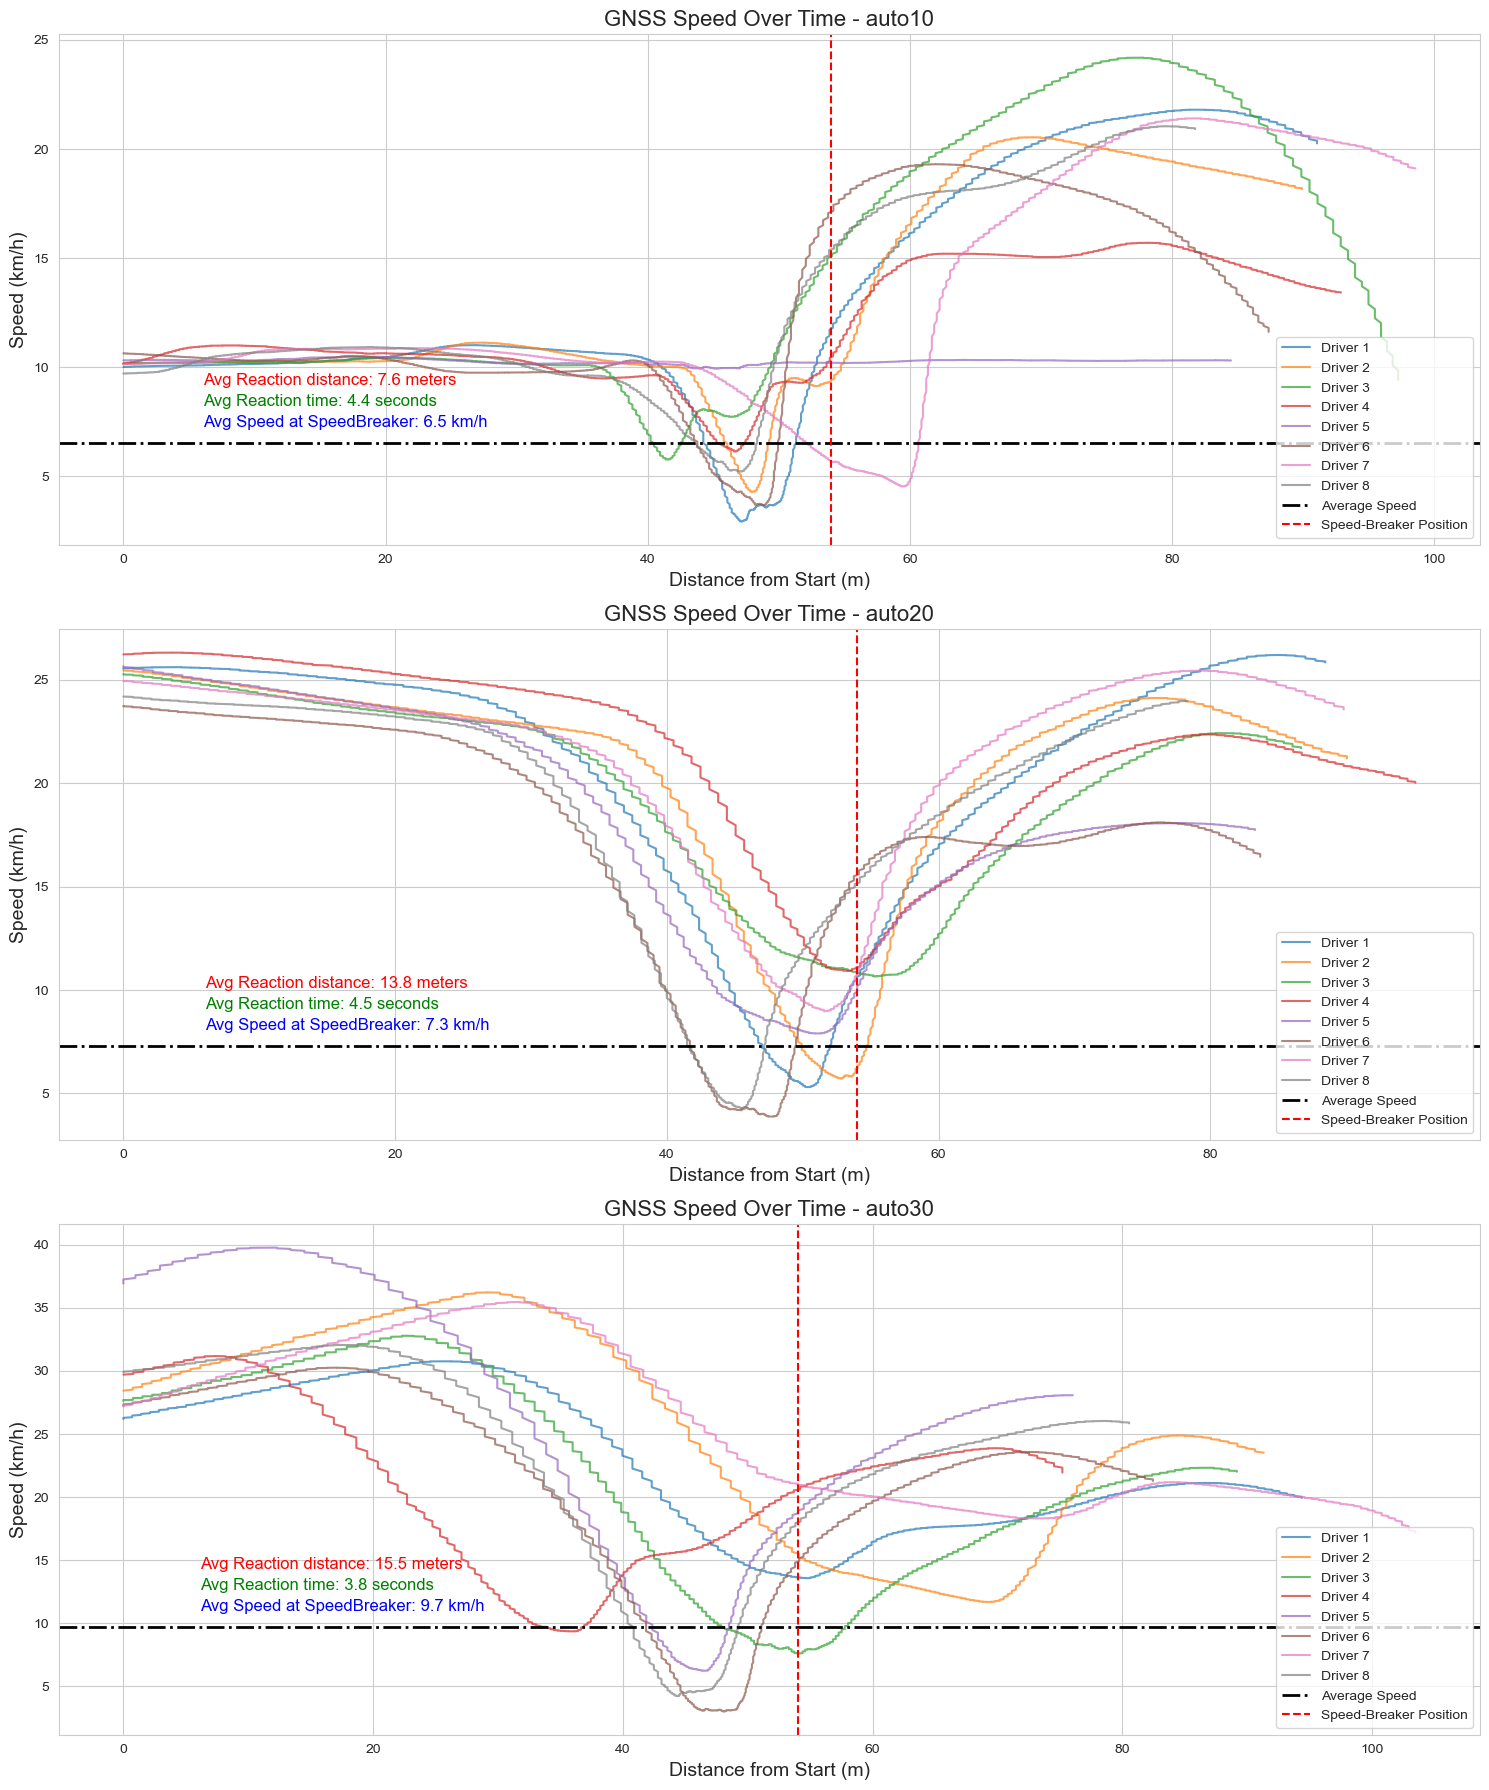

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style("whitegrid")

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Create a figure with 3 subplots (one for each dataset)
fig, axs = plt.subplots(num_datasets, 1, figsize=(15, 6 * num_datasets))

# Use a colormap for user differentiation
cmap = plt.get_cmap('tab10')

# Define a moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size = 50  # or any other size depending on your data

for i, (df_name, df) in enumerate(next(iter(data.values())).items()):  # Iterate over datasets
    
    for j, (user_name, user_data) in enumerate(data.items()):  # Iterate over users
        user_df = user_data[df_name]  # Get the specific dataset for the current user

        x_value = 54
        # Apply moving average to the speed data
        smoothed_speed = moving_average(user_df['Veh_GNSS_Speed'].values, window_size)

        # Plot all users' data on the same subplot for the current dataset
        axs[i].plot(user_df['dist_from_start'][:-window_size+1], smoothed_speed, label=f'Driver {j+1}', color=cmap(j % 10), alpha=0.7)

    if 'auto10' in df_name:
        axs[i].axhline(y=mean_speed['auto10'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto10']
        avg_reacton_time = mean_time['auto10']
        avg_reaction_distance = reaction_distance['auto10']
    elif 'auto20' in df_name:
        axs[i].axhline(y=mean_speed['auto20'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto20']
        avg_reacton_time = mean_time['auto20']
        avg_reaction_distance = reaction_distance['auto20']
    elif 'auto30' in df_name:
        axs[i].axhline(y=mean_speed['auto30'], color='black', linestyle='-.', label='Average Speed', linewidth=2)
        avg_x_value_speed = mean_speed['auto30']
        avg_reacton_time = mean_time['auto30']
        avg_reaction_distance = reaction_distance['auto30']

    # Draw a vertical line at x_value and annotate it with the average speed at that point
    axs[i].axvline(x=x_value, color='r', linestyle='--', label='Speed-Breaker Position')
    axs[i].annotate(f'Avg Speed at SpeedBreaker: {avg_x_value_speed:.1f} km/h', (5, avg_x_value_speed), xytext=(10, 15),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='blue')
    axs[i].annotate(f'Avg Reaction time: {avg_reacton_time:.1f} seconds', (5, avg_x_value_speed), xytext=(10, 30),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='green')
    axs[i].annotate(f'Avg Reaction distance: {avg_reaction_distance:.1f} meters', (5, avg_x_value_speed), xytext=(10, 45),
                    textcoords='offset points', va='center', ha='left', fontsize=12, color='red')

    axs[i].set_xlabel('Distance from Start (m)', fontsize=14)
    axs[i].set_ylabel('Speed (km/h)', fontsize=14)
    axs[i].set_title(f'GNSS Speed Over Time - {df_name}', fontsize=16)
    axs[i].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


### Multiple Plots for each users

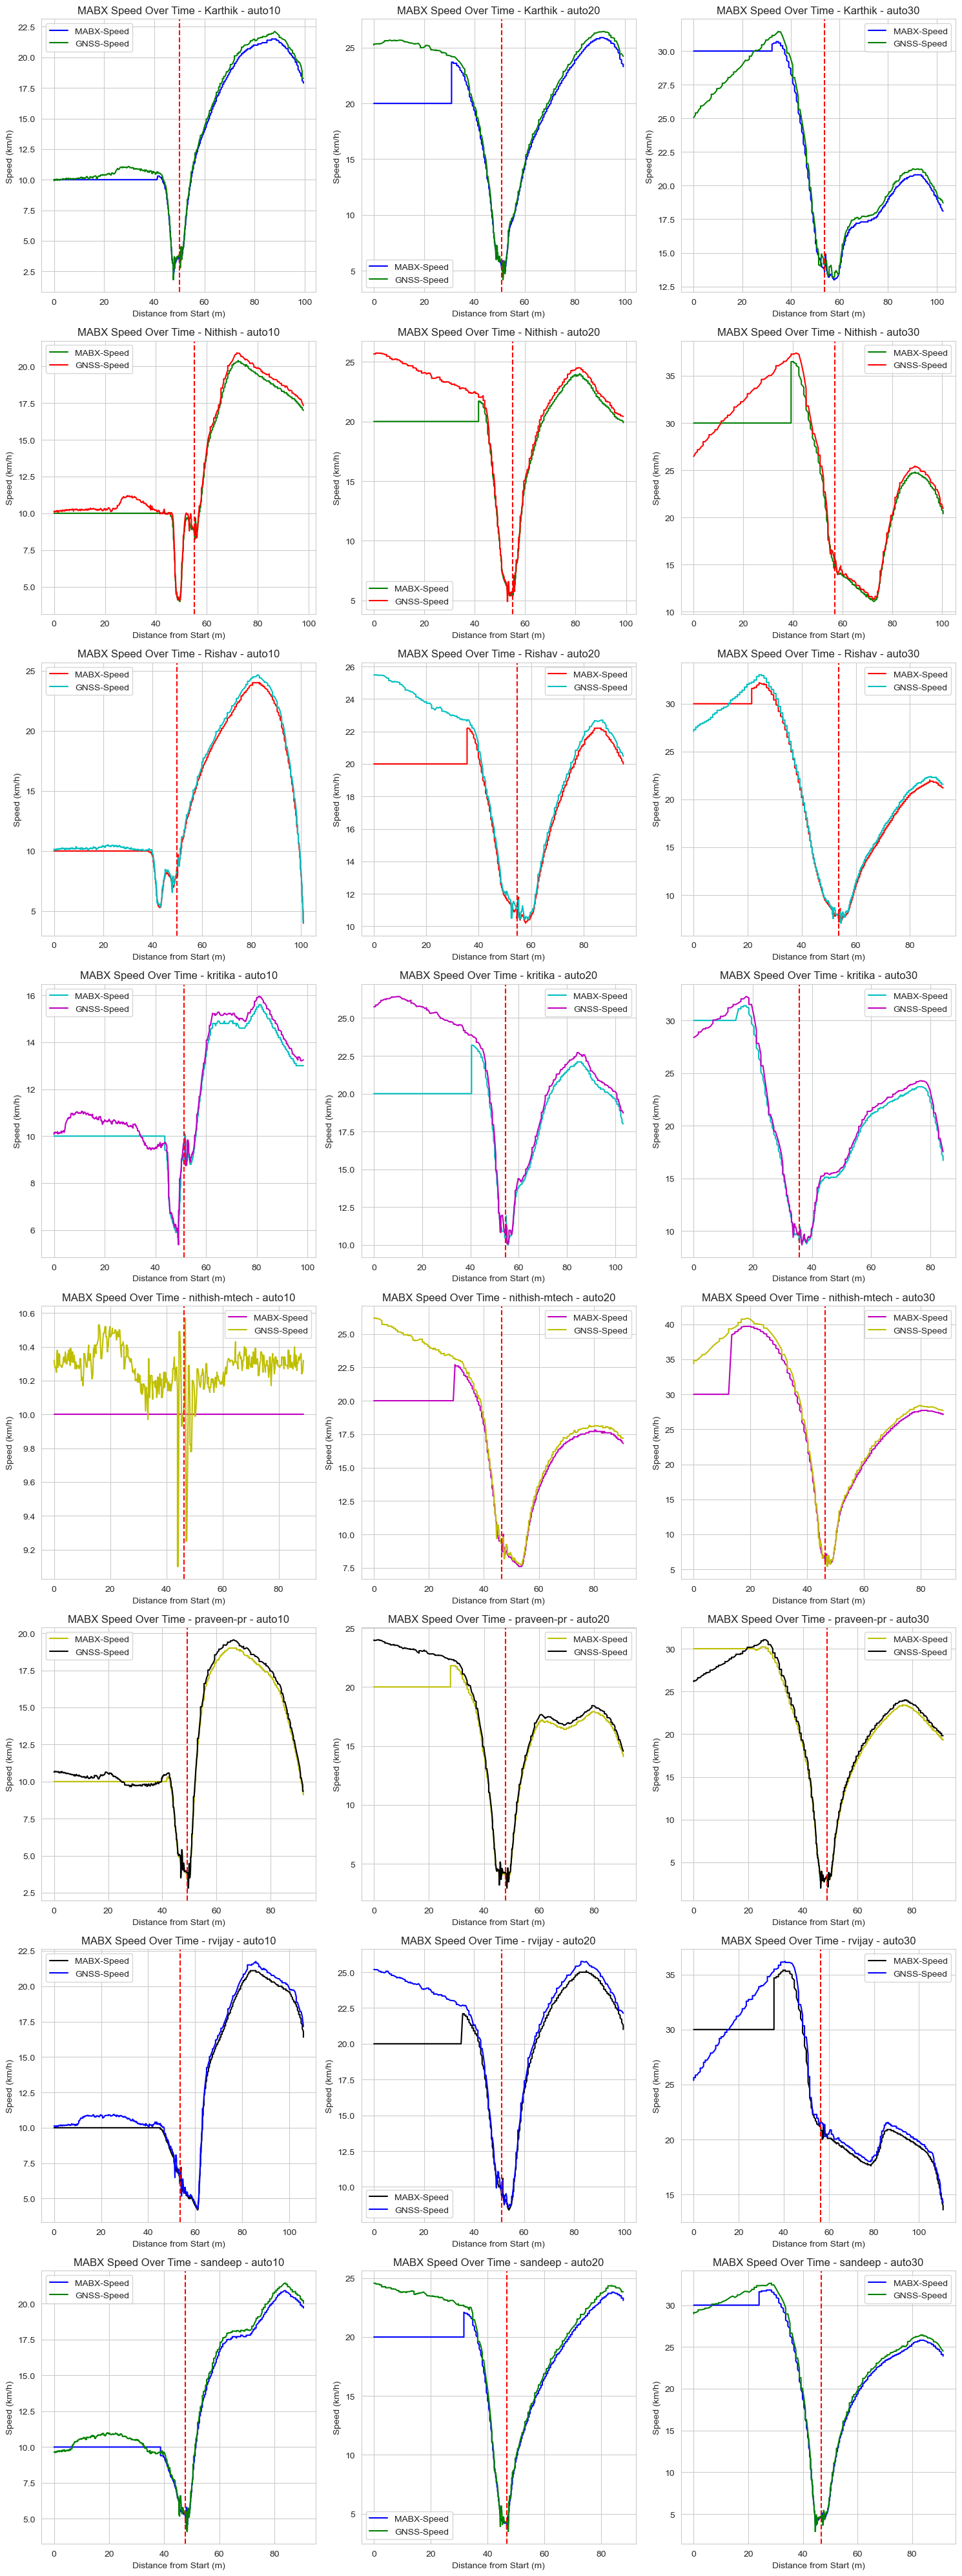

In [282]:
import matplotlib.pyplot as plt

# Determine the number of users and datasets
num_users = len(data)
num_datasets = len(next(iter(data.values())))

# Flatten the 2D array of subplots into a 1D array
fig, axs = plt.subplots(num_users, num_datasets, figsize=(15, 5*num_users))
axs_flat = axs.flatten()

# Define a list of colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for j, (user_name, user_data) in enumerate(data.items()):
    for i, (df_name, df) in enumerate(user_data.items()):
        # Extract x value from current dataframe based on the specified condition
        x_value = df.loc[(df['Z_Acc'] > 12), ['dist_from_start']]['dist_from_start'].values[1]

        axs_flat[j * num_datasets + i].plot(df['dist_from_start'], df['Veh_MABX_Speed'], label=f'MABX-Speed', color=colors[j % len(colors)])
        axs_flat[j * num_datasets + i].plot(df['dist_from_start'], df['Veh_GNSS_Speed'], label=f'GNSS-Speed', color=colors[(j + 1) % len(colors)])

        axs_flat[j * num_datasets + i].set_xlabel('Distance from Start (m)')
        axs_flat[j * num_datasets + i].set_ylabel('Speed (km/h)')
        axs_flat[j * num_datasets + i].set_title(f'MABX Speed Over Time - {user_name} - {df_name}')
        axs_flat[j * num_datasets + i].legend()

        # Draw a vertical line at x_value
        axs_flat[j * num_datasets + i].axvline(x=x_value, color='r', linestyle='--')

plt.tight_layout()
plt.show()


### Plot with rest to Time

In [283]:
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# for i, (df_name, df) in enumerate(data['Rishav'].items()):
#     # Extract x value from current dataframe based on the specified condition
#     x_value = df.loc[(df['Z_Acc'] > 10), ['dist_from_start']]['dist_from_start'].values[50]

#     # x_value_end = df.loc[(df['Z_Acc'] < 6) | (df['Z_Acc'] > 15), ['dist_from_start']]['dist_from_start'].values[-1]

#     axs[i].plot(df['dist_from_start'], df['Veh_GNSS_Speed'], label=f'Speed')
#     # axs[i].plot(df['Roll'], label=f'Pitch')

#     axs[i].set_xlabel('Timestamp')
#     axs[i].set_ylabel('Speed (km/h)')
#     axs[i].set_title(f'GNSS Speed Over Time - {df_name}')
#     axs[i].legend()

#     # Draw a vertical line at x_value
#     axs[i].axvline(x=x_value, color='r', linestyle='--')
#     # axs[i].axvline(x=x_value_end, color='r', linestyle='--')

# plt.tight_layout()
# plt.show()


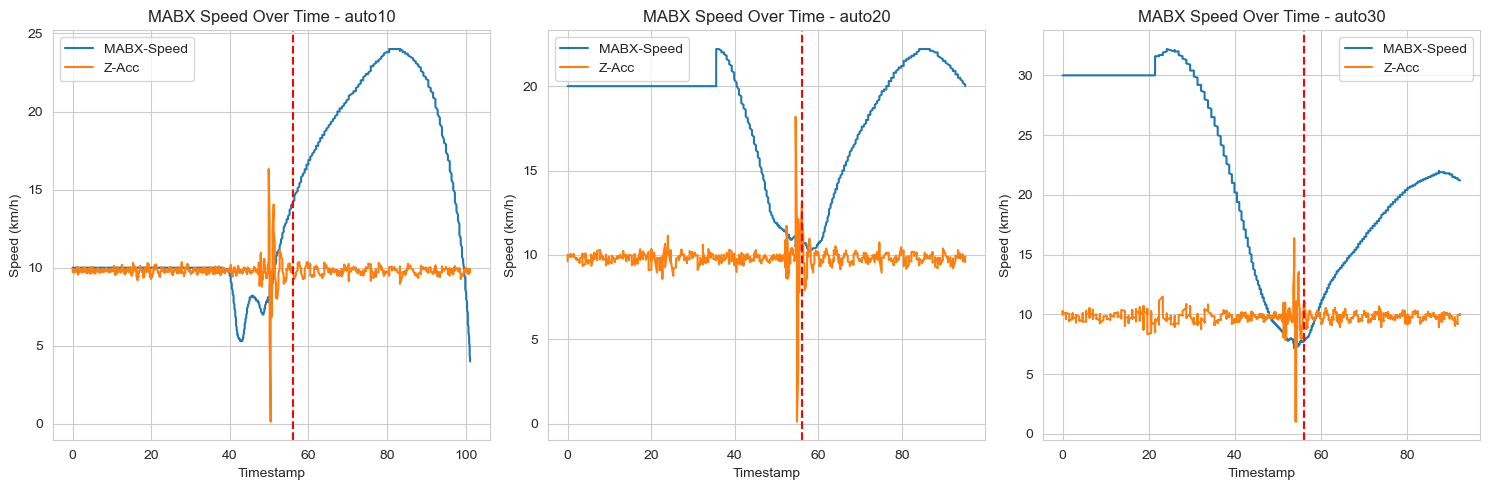

In [284]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (df_name, df) in enumerate(data['Rishav'].items()):

    # Extract x value from current dataframe based on the specified condition
    x_value = 56

    # x_value_end = df.loc[(df['Z_Acc'] < 6) | (df['Z_Acc'] > 15), ['dist_from_start']]['dist_from_start'].values[-1]

    axs[i].plot(df['dist_from_start'], df['Veh_MABX_Speed'], label=f'MABX-Speed')
    # axs[i].plot(df['dist_from_start'], df['Veh_GNSS_Speed'], label=f'GNSS-Speed')
    axs[i].plot(df['dist_from_start'], df['Z_Acc'], label=f'Z-Acc')
    # axs[i].plot(df['Roll'], label=f'Pitch')

    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Speed (km/h)')
    axs[i].set_title(f'MABX Speed Over Time - {df_name}')
    axs[i].legend()

    # Draw a vertical line at x_value
    axs[i].axvline(x=x_value, color='r', linestyle='--')
    # axs[i].axvline(x=x_value_end, color='r', linestyle='--')

plt.tight_layout()
plt.show()
